In [ ]:
%%capture
import os, re
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    # Do this only in Colab notebooks! Otherwise use pip install unsloth
    import torch; v = re.match(r"[0-9\.]{3,}", str(torch.__version__)).group(0)
    xformers = "xformers==" + ("0.0.32.post2" if v == "2.8.0" else "0.0.29.post3")
    !pip install --no-deps bitsandbytes accelerate {xformers} peft trl triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf "datasets>=3.4.1,<4.0.0" "huggingface_hub>=0.34.0" hf_transfer
    !pip install --no-deps unsloth
!pip install transformers==4.57.0
!pip install --no-deps trl==0.22.2

In [ ]:
# %%capture
# !wget https://huggingface.co/datasets/barryallen16/fitcheck-annotate-dataset/resolve/main/fitcheck-dataset.zip
# !unzip fitcheck-dataset.zip
!curl -L "https://drive.usercontent.google.com/download?id=1MdWBJxO7wQrD00_rBDKX8NbRrxRcKgff&export=download&authuser=0&confirm=t" -o indofashion_dataset.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2762M  100 2762M    0     0  60.8M      0  0:00:45  0:00:45 --:--:-- 71.5M


In [ ]:
%%capture
!unzip indofashion_dataset.zip

In [ ]:
!pip install qwen-vl-utils

import torch
from unsloth import FastVisionModel
from qwen_vl_utils import process_vision_info
import json
from PIL import Image
import os
import pandas as pd
import time
from tqdm import tqdm

print("Loading Qwen3-VL with Unsloth optimization...")

# Load model with Unsloth - Much faster and more memory efficient!
model, processor = FastVisionModel.from_pretrained(
    # "unsloth/Qwen2.5-VL-7B-Instruct-unsloth-bnb-4bit",  # 7B model now fits in memory!
    "unsloth/Qwen3-VL-8B-Instruct-unsloth-bnb-4bit",
    load_in_4bit=True,
    use_gradient_checkpointing="unsloth",  # Unsloth's optimized checkpointing
)

# Enable inference mode (important for speed)
FastVisionModel.for_inference(model)

print("✅ Model loaded with Unsloth optimization!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 MB 21.9 MB/s eta 0:00:00
🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
Loading Qwen3-VL with Unsloth optimization...
==((====))==  Unsloth 2025.10.6: Fast Qwen3_Vl patching. Transformers: 4.57.0.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.4.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.32.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.72G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/213 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/782 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/707 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

video_preprocessor_config.json:   0%|          | 0.00/817 [00:00<?, ?B/s]

✅ Model loaded with Unsloth optimization!


In [12]:
# @title
def classify_clothing_unsloth(image_path, context=None):
    """
    Classify clothing using Unsloth-optimized Qwen3-VL model
    Returns structured JSON metadata

    Args:
        image_path: Path to the image file
        context: Optional context string to guide classification (e.g., "women's festive wear", "men's traditional")
    """

    # Load image
    image = Image.open(image_path).convert('RGB')

    # Detailed prompt for Indian ethnic wear
    base_prompt = """Analyze this clothing item image. Focus only on the garment, ignore background and people."""

    # Add context if provided
    if context:
        base_prompt += f"\n\nContext: {context}"

    base_prompt += """

Provide detailed analysis in ONLY valid JSON format:

{
  "specific_type": "detailed garment name (e.g., silk saree, embroidered women kurta, denim jeans, cotton shirt)",
  "category": "Choose the MOST ACCURATE category from: saree/women_kurta/leggings_salwar/palazzo/lehenga/dupatta/blouse/gown/dhoti_pants/petticoats/women_mojari/women_anarkali_kurta/women_a_line_kurta/men_kurta/nehru_jacket/sherwani/men_mojari/men_pagdi/shirt/t_shirt/jeans/trousers/pants/skirt/jacket/other",
  "color_primary": "dominant color with shade (e.g., deep maroon, light blue)",
  "color_secondary": ["secondary color1", "secondary color2"] or [] if none,
  "pattern": "design pattern: floral/paisley/solid/geometric/embroidery/prints/striped/checkered/plain",
  "material": "fabric type: silk/cotton/chiffon/georgette/denim/linen/crepe/velvet/brocade/chanderi/banarasi/polyester/khadi",
  "style": "traditional/contemporary/fusion/casual/formal/festive/western",
  "occasions": ["wedding", "festival", "casual", "office", "party", "daily_wear", "formal"],
  "weather": ["summer", "winter", "monsoon", "all_season"],
  "formality": "casual/semi_formal/formal/festive",
  "embellishments": ["embroidery", "sequins", "prints", "zari_work", "mirror_work", "gota_patti", "stone_work", "thread_work"] or ["plain"] if no embellishments,
  "gender": "male/female/unisex",
  "fit": "loose/fitted/flowy/structured/regular/straight",
  "blouse_details": {
    "visible": true/false,
    "color": "ACTUAL blouse color if CLEARLY visible, null if not visible or unclear",
    "pattern": "blouse pattern ONLY if clearly visible (solid/embroidered/printed/striped), null if not visible",
    "sleeve_style": "ONLY if sleeves are clearly visible: full_sleeve/half_sleeve/sleeveless/three_quarter, null if not visible",
    "neckline": "ONLY if neckline is clearly visible: round/v_neck/boat_neck/square/high_neck/sweetheart/halter, null if not visible",
    "embellishments": ["embroidery", "sequins", "zari_work"] or ["plain"] if no embellishments, null if not visible,
    "material": "blouse fabric if distinguishable (silk/cotton/chiffon), null if not visible",
    "match_level": "perfect_match/complementary/contrasting, null if not visible"
  } or null if category is not saree or blouse not visible
}

IMPORTANT CLASSIFICATION RULES:
- For regular shirts (button-down): use category "shirt"
- For jeans: use category "jeans"
- For regular trousers/pants: use category "trousers" or "pants"
- For traditional Indian kurtas: use "men_kurta" or "women_kurta"
- For anarkali style: use "women_anarkali_kurta"
- For palazzo pants: use "palazzo"
- For salwar/churidar: use "leggings_salwar"
- Only use ethnic categories (saree, lehenga, sherwani, etc.) for traditional Indian wear
- If unsure, use "other" rather than forcing an incorrect ethnic category
- For embellishments: use ["plain"] if garment has no decorative work, use [] empty list should be avoided

CRITICAL BLOUSE ANALYSIS RULES (for sarees only):
- BE VERY CAREFUL: Only describe what you can ACTUALLY SEE in the image
- If category is NOT "saree", return null for entire "blouse_details"
- If category IS "saree" but blouse is not visible, return null for entire "blouse_details"
- Set "visible": true ONLY if you can clearly see the blouse in the image
- Set "visible": false if:
  * Only the saree is visible (product shot without model)
  * Blouse is covered or not in frame
  * Image shows only draped saree without blouse
- DO NOT assume or guess blouse details:
  * If you cannot see the blouse color clearly, use null
  * If sleeves are not visible or unclear, use null for "sleeve_style"
  * If neckline is not visible (covered by saree pallu, not in frame, or unclear), use null for "neckline"
  * If embellishments cannot be determined, use null
- DO NOT copy saree color/pattern to blouse unless you can actually see a matching blouse
- For "match_level":
  * Only assess if blouse is clearly visible
  * Use null if blouse is not visible or details are unclear

Return ONLY the JSON object, no other text."""
    prompt = base_prompt

    messages = [
        {
            "role": "user",
            "content": [
                {"type": "image", "image": image},
                {"type": "text", "text": prompt}
            ]
        }
    ]

    # Prepare inputs
    text = processor.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )

    image_inputs, video_inputs = process_vision_info(messages)

    inputs = processor(
        text=[text],
        images=image_inputs,
        videos=video_inputs,
        padding=True,
        return_tensors="pt"
    )

    inputs = inputs.to("cuda")

    # Generate classification with Unsloth optimization
    with torch.no_grad():
        generated_ids = model.generate(
            **inputs,
            max_new_tokens=512,
            temperature=0.3,
            use_cache=True  # Unsloth optimizes KV cache
        )

    # Decode output
    generated_ids_trimmed = [
        out_ids[len(in_ids):]
        for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
    ]

    output_text = processor.batch_decode(
        generated_ids_trimmed,
        skip_special_tokens=True,
        clean_up_tokenization_spaces=False
    )[0]

    # Parse JSON
    try:
        json_start = output_text.find('{')
        json_end = output_text.rfind('}') + 1
        json_str = output_text[json_start:json_end]
        classification = json.loads(json_str)

        # Check for template responses
        if (classification.get("specific_type") == "detailed garment name (e.g., silk saree, embroidered kurti)" or
            classification.get("category") == "exact category: kurta/kurti/palazzo/churidar/salwar/saree/lehenga/anarkali_suit/gown/dupatta/blouse/choli/dhoti_pants/skirt/shirt/t_shirt/jeans/trousers/crop_top/peplum_top/anarkali_top/cape/jacket/shawl/lehenga_set"):
            print(f"Warning: Template response for {image_path}")
            return None

        return classification
    except json.JSONDecodeError:
        print(f"Warning: Could not parse JSON for {image_path}")
        return None
    except Exception as e:
        print(f"Error parsing for {image_path}: {e}")
        return None

In [ ]:
# @title
def process_indofashion_unsloth(base_path, output_csv, output_jsonl, batch_size=1, context_mapper=None):
    """
    Process IndoFashion dataset with Unsloth optimization
    Saves results in both CSV and JSONL formats

    Args:
        base_path: Path to the dataset folder
        output_csv: Output CSV filename
        output_jsonl: Output JSONL filename
        batch_size: Keep at 1 for image processing (models process images one at a time)
        context_mapper: Optional function that takes image_path and returns context string
                       Example: lambda path: "women's festive wear" if "women" in path else "men's wear"
    """
    results = []
    image_files = []

    # Collect all image paths
    for folder_name in os.listdir(base_path):
        folder_path = os.path.join(base_path, folder_name)
        if os.path.isdir(folder_path):
            for image_name in os.listdir(folder_path):
                if image_name.lower().endswith(('.png', '.jpg', '.jpeg', '.webp')):
                    image_files.append(os.path.join(folder_path, image_name))

    print(f"\n{'='*80}")
    print(f"Processing {len(image_files)} images with Unsloth-optimized Qwen3-VL-4B")
    print(f"Expected speedup: 2-5x faster than standard implementation")
    print(f"{'='*80}\n")

    start_time = time.time()

    # Process with progress bar
    for idx, image_path in enumerate(tqdm(image_files, desc="Classifying")):
        try:
            # Get context if mapper is provided
            context = context_mapper(image_path) if context_mapper else None

            classification = classify_clothing_unsloth(image_path, context=context)

            if classification:
                result_entry = {
                    'filename': os.path.basename(image_path),
                    'image_path': image_path,
                    'classification': classification
                }
                results.append(result_entry)

            # Save checkpoint every 50 images
            if (idx + 1) % 50 == 0:
                temp_df = pd.DataFrame(results)
                temp_df.to_csv(f"checkpoint_unsloth_{idx+1}.csv", index=False)

                # Save JSONL checkpoint
                with open(f"checkpoint_unsloth_{idx+1}.jsonl", 'w') as f:
                    for item in results:
                        f.write(json.dumps(item) + '\n')

                print(f"\nCheckpoint saved: {idx+1} images processed")

        except Exception as e:
            print(f"\n Error processing {image_path}: {e}")
            continue

    # Calculate metrics
    elapsed_time = time.time() - start_time

    # Save final results
    df = pd.DataFrame(results)
    df.to_csv(output_csv, index=False)

    # Save as JSONL
    with open(output_jsonl, 'w') as f:
        for item in results:
            f.write(json.dumps(item) + '\n')

    print(f"\n{'='*80}")
    print(f"Processing Complete!")
    print(f"Processed: {len(results)} images")
    print(f"Time taken: {elapsed_time/60:.1f} minutes")
    if len(results) > 0:
        print(f"Average: {elapsed_time/len(results):.2f} seconds per image")
    print(f"Saved to CSV: {output_csv}")
    print(f"Saved to JSONL: {output_jsonl}")
    print(f"{'='*80}\n")

    return df

In [ ]:
# @title
def get_context_from_path(image_path):
    return f"image path: {image_path}"

In [ ]:
# @title
# def get_context_from_path(image_path):
    # """Extract context from folder structure or filename"""
    # folder_name = os.path.basename(os.path.dirname(image_path)).lower()
    # # Example mappings based on your dataset structure
    # if 'women' in folder_name or 'female' in folder_name:
    #     return "women's ethnic wear"
    # elif 'men' in folder_name or 'male' in folder_name:
    #     return "men's ethnic wear"
    # elif 'saree' in folder_name:
    #     return "traditional saree"
    # elif 'kurta' in folder_name:
    #     return "kurta/kurti"
    # elif 'lehenga' in folder_name:
    #     return "festive lehenga"
    # elif 'sherwani' in folder_name or 'nehru' in folder_name:
    #     return "men's formal traditional wear"
    # else:
    #     return None  # No context if unclear

In [ ]:
# @title
# df = process_indofashion_unsloth("fitcheck-dataset/")
df = process_indofashion_unsloth(
        "fitcheck-dataset/",
        output_csv="fitcheck_annotate_dataset_v3.csv",
        output_jsonl="fitcheck_annotate_dataset_v3.jsonl",
        context_mapper=get_context_from_path
    )


Image path: images/val/0.jpeg
Product Title: Women's Khadi Cotton Saree With Blouse Piece (UFO301119SOLD_KHDI_1_Grey)
Class Label: saree


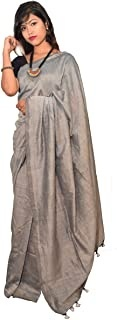

Classification: {'specific_type': 'khadi cotton saree', 'category': 'saree', 'color_primary': 'grey', 'color_secondary': [], 'pattern': 'plain', 'material': 'khadi', 'style': 'traditional', 'occasions': ['casual', 'daily_wear', 'office'], 'weather': ['all_season'], 'formality': 'casual', 'embellishments': ['plain'], 'gender': 'female', 'fit': 'flowy', 'blouse_details': {'visible': False, 'color': None, 'pattern': None, 'sleeve_style': None, 'neckline': None, 'embellishments': None, 'material': None, 'match_level': None}}
--------------------
Image path: images/val/1.jpeg
Product Title: Women's Net Saree With Unstitched Blouse Piece
Class Label: saree


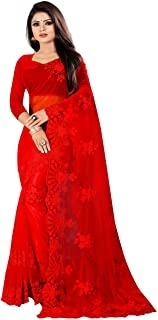

Classification: {'specific_type': 'red net saree with lace detailing', 'category': 'saree', 'color_primary': 'vibrant red', 'color_secondary': [], 'pattern': 'floral', 'material': 'net', 'style': 'traditional', 'occasions': ['wedding', 'festival', 'party', 'formal'], 'weather': ['summer', 'all_season'], 'formality': 'formal', 'embellishments': ['embroidery', 'lace'], 'gender': 'female', 'fit': 'flowy', 'blouse_details': {'visible': True, 'color': 'red', 'pattern': 'solid', 'sleeve_style': 'full_sleeve', 'neckline': 'round', 'embellishments': ['embroidery'], 'material': 'net', 'match_level': 'perfect_match'}}
--------------------
Image path: images/val/2.jpeg
Product Title: Georgette Strip Print Saree[S_SHIKHA30021SR02_perent_Red & Yellow]
Class Label: saree


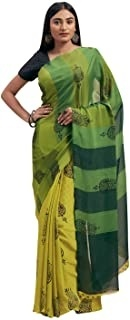

Classification: {'specific_type': 'georgette strip print saree', 'category': 'saree', 'color_primary': 'green', 'color_secondary': ['yellow', 'dark_green'], 'pattern': 'striped', 'material': 'georgette', 'style': 'traditional', 'occasions': ['festival', 'party', 'daily_wear', 'formal'], 'weather': ['summer', 'all_season'], 'formality': 'formal', 'embellishments': ['prints'], 'gender': 'female', 'fit': 'flowy', 'blouse_details': {'visible': True, 'color': 'black', 'pattern': 'solid', 'sleeve_style': 'half_sleeve', 'neckline': 'round', 'embellishments': ['plain'], 'material': 'cotton', 'match_level': 'contrasting'}}
--------------------
Image path: images/val/3.jpeg
Product Title: Women's Patola Style Art Silk Saree (Green)
Class Label: saree


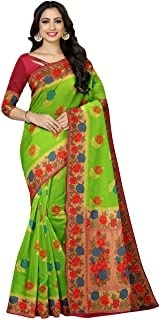

Classification: {'specific_type': 'Art Silk Saree', 'category': 'saree', 'color_primary': 'green', 'color_secondary': ['red', 'blue', 'orange', 'gold'], 'pattern': 'floral', 'material': 'art_silk', 'style': 'traditional', 'occasions': ['festival', 'party', 'wedding', 'formal'], 'weather': ['summer', 'all_season'], 'formality': 'formal', 'embellishments': ['prints'], 'gender': 'female', 'fit': 'flowy', 'blouse_details': {'visible': True, 'color': 'red', 'pattern': 'solid', 'sleeve_style': 'three_quarter', 'neckline': 'round', 'embellishments': ['plain'], 'material': 'art_silk', 'match_level': 'complementary'}}
--------------------
Image path: images/val/4.jpeg
Product Title: Women's Pure Hand Block Patola Printed Cotton Mulmul Saree with Pompom Lace and Plan Black Blouse (chhipaif050, Red)
Class Label: saree


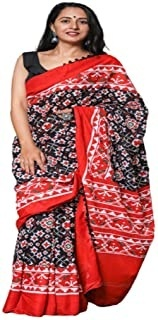

Classification: {'specific_type': 'cotton mulmul saree with pompom lace', 'category': 'saree', 'color_primary': 'red', 'color_secondary': ['black', 'white'], 'pattern': 'prints', 'material': 'cotton', 'style': 'traditional', 'occasions': ['festival', 'party', 'daily_wear', 'formal'], 'weather': ['summer', 'all_season'], 'formality': 'formal', 'embellishments': ['prints', 'pompom lace'], 'gender': 'female', 'fit': 'flowy', 'blouse_details': {'visible': True, 'color': 'black', 'pattern': 'solid', 'sleeve_style': 'sleeveless', 'neckline': 'round', 'embellishments': ['plain'], 'material': 'cotton', 'match_level': 'complementary'}}
--------------------
Image path: images/val/5.jpeg
Product Title: Women's Georgette Polka Dot Saree With Blouse(priyanka-polka-dot-grey)
Class Label: saree


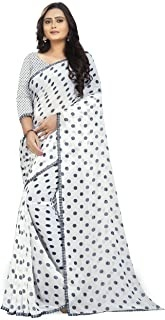

Classification: {'specific_type': 'georgette polka dot saree', 'category': 'saree', 'color_primary': 'white', 'color_secondary': ['black'], 'pattern': 'polka dot', 'material': 'georgette', 'style': 'contemporary', 'occasions': ['party', 'festive', 'casual', 'daily_wear'], 'weather': ['summer', 'all_season'], 'formality': 'casual', 'embellishments': ['prints'], 'gender': 'female', 'fit': 'flowy', 'blouse_details': {'visible': True, 'color': 'grey', 'pattern': 'solid', 'sleeve_style': 'three_quarter', 'neckline': 'round', 'embellishments': ['plain'], 'material': 'georgette', 'match_level': 'complementary'}}
--------------------
Image path: images/val/6.jpeg
Product Title: Gadwaal pure cotton Pink Saree - MK4248
Class Label: saree


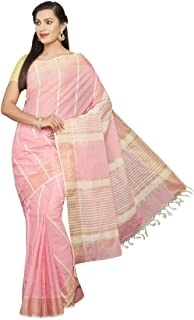

Classification: {'specific_type': 'pure cotton saree', 'category': 'saree', 'color_primary': 'pink', 'color_secondary': ['beige', 'cream', 'gold'], 'pattern': 'striped', 'material': 'cotton', 'style': 'traditional', 'occasions': ['festival', 'party', 'daily_wear', 'wedding'], 'weather': ['summer', 'all_season'], 'formality': 'semi_formal', 'embellishments': ['plain'], 'gender': 'female', 'fit': 'flowy', 'blouse_details': {'visible': True, 'color': 'yellow', 'pattern': 'solid', 'sleeve_style': 'half_sleeve', 'neckline': 'round', 'embellishments': ['plain'], 'material': 'cotton', 'match_level': 'complementary'}}
--------------------
Image path: images/val/7.jpeg
Product Title: Women's Assamese Weaving Art Khadi Silk Mekhela Chador Saree - Mekhla Sador (Dn19, Chiku and Multicolor)
Class Label: saree


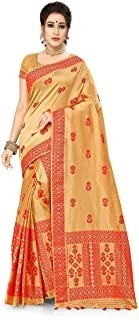

Classification: {'specific_type': 'Assamese Weaving Art Khadi Silk Mekhela Chador Saree', 'category': 'saree', 'color_primary': 'golden beige', 'color_secondary': ['orange', 'red'], 'pattern': 'geometric', 'material': 'khadi', 'style': 'traditional', 'occasions': ['festival', 'wedding', 'formal', 'party'], 'weather': ['all_season'], 'formality': 'formal', 'embellishments': ['prints', 'zari_work'], 'gender': 'female', 'fit': 'flowy', 'blouse_details': {'visible': True, 'color': 'golden beige', 'pattern': 'solid', 'sleeve_style': 'half_sleeve', 'neckline': 'round', 'embellishments': ['zari_work'], 'material': 'khadi', 'match_level': 'perfect_match'}}
--------------------
Image path: images/val/8.jpeg
Product Title: Women Chanderi Silk Saree With Blouse Piece (Beige)
Class Label: saree


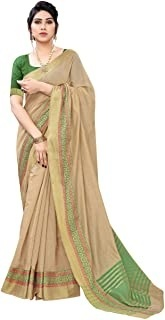

Classification: {'specific_type': 'Chanderi silk saree', 'category': 'saree', 'color_primary': 'beige', 'color_secondary': ['green'], 'pattern': 'striped', 'material': 'chanderi', 'style': 'traditional', 'occasions': ['wedding', 'festival', 'party', 'formal'], 'weather': ['all_season'], 'formality': 'formal', 'embellishments': ['prints'], 'gender': 'female', 'fit': 'flowy', 'blouse_details': {'visible': True, 'color': 'green', 'pattern': 'solid', 'sleeve_style': 'half_sleeve', 'neckline': 'round', 'embellishments': ['plain'], 'material': 'cotton', 'match_level': 'complementary'}}
--------------------
Image path: images/val/9.jpeg
Product Title: X SUNEET VARMA Women's Georgette and Pattern Mesh Ruffle Saree & Solid Blouse
Class Label: saree


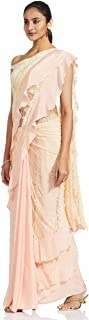

Classification: {'specific_type': 'Georgette and Pattern Mesh Ruffle Saree', 'category': 'saree', 'color_primary': 'light pink', 'color_secondary': [], 'pattern': 'ruffle', 'material': 'georgette', 'style': 'contemporary', 'occasions': ['party', 'festive', 'formal'], 'weather': ['summer', 'all_season'], 'formality': 'formal', 'embellishments': ['ruffle'], 'gender': 'female', 'fit': 'flowy', 'blouse_details': {'visible': True, 'color': 'light pink', 'pattern': 'solid', 'sleeve_style': 'sleeveless', 'neckline': 'boat_neck', 'embellishments': ['plain'], 'material': 'georgette', 'match_level': 'perfect_match'}}
--------------------
Limit of 10 lines reached.

Total lines processed: 10
Processing stopped at line limit of 10


In [6]:
import json
import os
from PIL import Image

file_path = 'val_data.json' # Assuming this is the file to count lines from
line_count = 0
line_limit = 10 # Set to an integer to limit processing, or None for no limit

if not os.path.exists(file_path):
    print(f"Error: File not found at {file_path}")
else:
    with open(file_path, 'r') as file:
        for line in file:
            if line_limit is not None and line_count >= line_limit:
                print(f"Limit of {line_limit} lines reached.")
                break # Stop processing if limit is reached

            try:
                data = json.loads(line)
                context_data=f"""Image path: {data.get('image_path')}\nProduct Title: {data.get('product_title')}\nClass Label: {data.get('class_label')}"""
                print(context_data)

                # Use IPython.display.Image to display the image
                img = Image.open(data.get('image_path'))
                display(img)
                # Use PIL.Image to open the image file for processing
                prompt, classification = classify_clothing_unsloth(data.get('image_path'), context=context_data)
                # print(f"prompt:{prompt}")
                print(f"Classification: {classification}")
                print("-" * 20)

                line_count += 1

            except json.JSONDecodeError as e:
                print(f"Error decoding JSON on line {line_count + 1}: {e}")

    print(f"\nTotal lines processed: {line_count}")
    if line_limit is not None:
        print(f"Processing stopped at line limit of {line_limit}")

In [18]:
def process_clothing_list_unsloth(data_list, output_csv, output_jsonl, context_mapper=None, limit=None):
    """
    Process a list of clothing items with Unsloth optimization
    Saves results in both CSV and JSONL formats
    Automatically resumes from where it left off

    Args:
        data_list: List of dictionaries with 'image_path' and optional context fields
                   Example: [{'image_path': 'path.jpg', 'product_title': 'Saree', 'class_label': 'saree'}, ...]
        output_csv: Output CSV filename
        output_jsonl: Output JSONL filename
        context_mapper: Optional function that takes data dict and returns context string
                       Example: lambda data: f"Product: {data.get('product_title')}"
                       If None, will use default context from data fields
        limit: Optional integer to limit number of images to process (None for no limit)
    """
    results = []
    processed_paths = set()

    # Load existing results if files exist
    if os.path.exists(output_jsonl):
        print(f"📂 Found existing output file: {output_jsonl}")
        print(f"🔄 Loading previously processed images...")
        try:
            with open(output_jsonl, 'r') as f:
                for line in f:
                    try:
                        item = json.loads(line.strip())
                        results.append(item)
                        processed_paths.add(item['image_path'])
                    except json.JSONDecodeError:
                        continue
            print(f"✅ Loaded {len(results)} previously processed images")
        except Exception as e:
            print(f"⚠️  Error loading existing file: {e}")
            print(f"🔄 Starting fresh...")
            results = []
            processed_paths = set()

    # Filter out already processed items
    items_to_process = [
        item for item in data_list
        if item.get('image_path') and item['image_path'] not in processed_paths
    ]

    # Apply limit if specified (only on unprocessed items)
    if limit is not None:
        remaining_to_process = limit - len(processed_paths)
        if remaining_to_process > 0:
            items_to_process = items_to_process[:remaining_to_process]
            print(f"⚠️  Processing limited to {remaining_to_process} more images (total target: {limit})")
        else:
            print(f"✅ Already processed {len(processed_paths)} images. Limit of {limit} reached.")
            items_to_process = []

    total_to_process = len(items_to_process)

    print(f"\n{'='*80}")
    print(f"📊 Total images already processed: {len(processed_paths)}")
    print(f"📊 New images to process: {total_to_process}")
    print(f"📊 Total after completion: {len(processed_paths) + total_to_process}")
    print(f"🚀 Using Unsloth-optimized Qwen3-VL-8B")
    print(f"{'='*80}\n")

    if total_to_process == 0:
        print("✅ All images already processed!")
        # Still save the existing results to CSV
        if results:
            df = pd.DataFrame(results)
            df.to_csv(output_csv, index=False)
            print(f"✅ Saved existing results to CSV: {output_csv}")
        return pd.DataFrame(results) if results else pd.DataFrame()

    start_time = time.time()

    # Process with progress bar
    for idx, data_item in enumerate(tqdm(items_to_process, desc="Classifying")):
        try:
            image_path = data_item.get('image_path')

            # Check if image file exists
            if not os.path.exists(image_path):
                print(f"\n⚠️  Image not found: {image_path}")
                continue

            # Build context using custom mapper or default
            if context_mapper:
                context = context_mapper(data_item)
            else:
                # Default context builder
                context_parts = []
                if 'image_path' in data_item:
                    context_parts.append(f"Image path: {data_item['image_path']}")
                if 'product_title' in data_item:
                    context_parts.append(f"Product Title: {data_item['product_title']}")
                if 'class_label' in data_item:
                    context_parts.append(f"Class Label: {data_item['class_label']}")

                context = "\n".join(context_parts) if context_parts else None
                print(f"Context: {context}")
            classification = classify_clothing_unsloth(image_path, context=context)

            if classification:
                result_entry = {
                    'filename': os.path.basename(image_path),
                    'image_path': image_path,
                    'classification': classification
                }


                processed_paths.add(image_path)

                # Append to JSONL immediately (for crash recovery)
                with open(output_jsonl, 'a') as f:
                    f.write(json.dumps(result_entry) + '\n')

            # Save checkpoint every 50 images
            if (idx + 1) % 50 == 0:
                temp_df = pd.DataFrame(results)
                temp_df.to_csv(output_csv, index=False)
                print(f"\n✅ Checkpoint saved: {len(results)} total images processed")

        except Exception as e:
            print(f"\n❌ Error processing {image_path}: {e}")
            continue

    # Calculate metrics
    elapsed_time = time.time() - start_time

    # Save final results to CSV
    df = pd.DataFrame(results)
    df.to_csv(output_csv, index=False)

    print(f"\n{'='*80}")
    print(f"✅ Processing Complete!")
    print(f"✅ Total images processed: {len(results)}")
    print(f"✅ New images processed in this run: {total_to_process}")
    if limit is not None:
        print(f"✅ Limit applied: {limit} images")
    print(f"✅ Time taken for new images: {elapsed_time/60:.1f} minutes")
    if total_to_process > 0:
        print(f"✅ Average: {elapsed_time/total_to_process:.2f} seconds per image")
    print(f"✅ Saved to CSV: {output_csv}")
    print(f"✅ Saved to JSONL: {output_jsonl}")
    print(f"{'='*80}\n")

    return df

In [21]:
import json

# Load data from your val_data.json
data_list = []
with open('val_data.json', 'r') as file:
    for line in file:
        try:
            data = json.loads(line)
            data_list.append(data)
        except json.JSONDecodeError as e:
            print(f"Error decoding JSON: {e}")

# Option 1: Use default context (includes all fields)
df = process_clothing_list_unsloth(
    data_list=data_list,
    output_csv="clothing_results.csv",
    output_jsonl="clothing_results.jsonl",
    limit=10  # Process first 10 images
)

📂 Found existing output file: clothing_results.jsonl
🔄 Loading previously processed images...
✅ Loaded 3 previously processed images
⚠️  Processing limited to 7 more images (total target: 10)

📊 Total images already processed: 3
📊 New images to process: 7
📊 Total after completion: 10
🚀 Using Unsloth-optimized Qwen3-VL-8B



Classifying:   0%|          | 0/7 [00:00<?, ?it/s]

Context: Image path: images/val/3.jpeg
Product Title: Women's Patola Style Art Silk Saree (Green)
Class Label: saree


Classifying:  14%|█▍        | 1/7 [00:27<02:42, 27.17s/it]

Context: Image path: images/val/4.jpeg
Product Title: Women's Pure Hand Block Patola Printed Cotton Mulmul Saree with Pompom Lace and Plan Black Blouse (chhipaif050, Red)
Class Label: saree


Classifying:  29%|██▊       | 2/7 [00:55<02:19, 27.90s/it]

Context: Image path: images/val/5.jpeg
Product Title: Women's Georgette Polka Dot Saree With Blouse(priyanka-polka-dot-grey)
Class Label: saree


Classifying:  43%|████▎     | 3/7 [01:22<01:49, 27.33s/it]

Context: Image path: images/val/6.jpeg
Product Title: Gadwaal pure cotton Pink Saree - MK4248
Class Label: saree


Classifying:  57%|█████▋    | 4/7 [01:49<01:21, 27.28s/it]

Context: Image path: images/val/7.jpeg
Product Title: Women's Assamese Weaving Art Khadi Silk Mekhela Chador Saree - Mekhla Sador (Dn19, Chiku and Multicolor)
Class Label: saree


Classifying:  71%|███████▏  | 5/7 [02:19<00:56, 28.11s/it]

Context: Image path: images/val/8.jpeg
Product Title: Women Chanderi Silk Saree With Blouse Piece (Beige)
Class Label: saree


Classifying:  86%|████████▌ | 6/7 [02:45<00:27, 27.68s/it]

Context: Image path: images/val/9.jpeg
Product Title: X SUNEET VARMA Women's Georgette and Pattern Mesh Ruffle Saree & Solid Blouse
Class Label: saree


Classifying: 100%|██████████| 7/7 [03:13<00:00, 27.60s/it]


✅ Processing Complete!
✅ Total images processed: 3
✅ New images processed in this run: 7
✅ Limit applied: 10 images
✅ Time taken for new images: 3.2 minutes
✅ Average: 27.60 seconds per image
✅ Saved to CSV: clothing_results.csv
✅ Saved to JSONL: clothing_results.jsonl



In [22]:
def process_clothing_list_unsloth(data_list, output_csv, output_jsonl, context_mapper=None, start=None, end=None):
    """
    Process a list of clothing items with Unsloth optimization
    Saves results in both CSV and JSONL formats
    Automatically resumes from where it left off

    Args:
        data_list: List of dictionaries with 'image_path' and optional context fields
                   Example: [{'image_path': 'path.jpg', 'product_title': 'Saree', 'class_label': 'saree'}, ...]
        output_csv: Output CSV filename
        output_jsonl: Output JSONL filename
        context_mapper: Optional function that takes data dict and returns context string
                       Example: lambda data: f"Product: {data.get('product_title')}"
                       If None, will use default context from data fields
        start: Optional starting index (inclusive, 0-based). Default is 0
        end: Optional ending index (exclusive). Default is None (process till end)
               Example: start=10, end=100 will process items 10-99 (90 items)
    """
    results = []
    processed_paths = set()

    # Set default start
    if start is None:
        start = 0

    # Validate start and end
    if start < 0:
        start = 0
    if end is not None and end > len(data_list):
        end = len(data_list)
    if end is not None and start >= end:
        print(f"❌ Error: start ({start}) must be less than end ({end})")
        return pd.DataFrame()

    # Load existing results if files exist
    if os.path.exists(output_jsonl):
        print(f"📂 Found existing output file: {output_jsonl}")
        print(f"🔄 Loading previously processed images...")
        try:
            with open(output_jsonl, 'r') as f:
                for line in f:
                    try:
                        item = json.loads(line.strip())
                        results.append(item)
                        processed_paths.add(item['image_path'])
                    except json.JSONDecodeError:
                        continue
            print(f"✅ Loaded {len(results)} previously processed images")
        except Exception as e:
            print(f"⚠️  Error loading existing file: {e}")
            print(f"🔄 Starting fresh...")
            results = []
            processed_paths = set()

    # Slice the data_list based on start and end
    if end is not None:
        selected_items = data_list[start:end]
        print(f"📌 Processing range: items {start} to {end-1} (total: {end-start} items)")
    else:
        selected_items = data_list[start:]
        print(f"📌 Processing range: items {start} to end (total: {len(selected_items)} items)")

    # Filter out already processed items
    items_to_process = [
        item for item in selected_items
        if item.get('image_path') and item['image_path'] not in processed_paths
    ]

    total_to_process = len(items_to_process)
    skipped = len(selected_items) - total_to_process

    print(f"\n{'='*80}")
    print(f"📊 Range: {start} to {end if end else len(data_list)}")
    print(f"📊 Items in range: {len(selected_items)}")
    print(f"📊 Already processed (skipped): {skipped}")
    print(f"📊 New images to process: {total_to_process}")
    print(f"📊 Total processed so far: {len(processed_paths)}")
    print(f"🚀 Using Unsloth-optimized Qwen2.5-VL-7B")
    print(f"{'='*80}\n")

    if total_to_process == 0:
        print("✅ All images in this range already processed!")
        # Still save the existing results to CSV
        if results:
            df = pd.DataFrame(results)
            df.to_csv(output_csv, index=False)
            print(f"✅ Saved existing results to CSV: {output_csv}")
        return pd.DataFrame(results) if results else pd.DataFrame()

    start_time = time.time()

    # Process with progress bar
    for idx, data_item in enumerate(tqdm(items_to_process, desc="Classifying")):
        try:
            image_path = data_item.get('image_path')

            # Check if image file exists
            if not os.path.exists(image_path):
                print(f"\n⚠️  Image not found: {image_path}")
                continue

            # Build context using custom mapper or default
            if context_mapper:
                context = context_mapper(data_item)
            else:
                # Default context builder
                context_parts = []
                if 'image_path' in data_item:
                    context_parts.append(f"Image path: {data_item['image_path']}")
                if 'product_title' in data_item:
                    context_parts.append(f"Product Title: {data_item['product_title']}")
                if 'class_label' in data_item:
                    context_parts.append(f"Class Label: {data_item['class_label']}")

                context = "\n".join(context_parts) if context_parts else None

            classification = classify_clothing_unsloth(image_path, context=context)

            if classification:
                result_entry = {
                    'filename': os.path.basename(image_path),
                    'image_path': image_path,
                    'classification': classification
                }

                processed_paths.add(image_path)

                # Append to JSONL immediately (for crash recovery)
                with open(output_jsonl, 'a') as f:
                    f.write(json.dumps(result_entry) + '\n')

            # Save checkpoint every 50 images
            if (idx + 1) % 50 == 0:
                temp_df = pd.DataFrame(results)
                temp_df.to_csv(output_csv, index=False)
                print(f"\n✅ Checkpoint saved: {len(results)} total images processed")

        except Exception as e:
            print(f"\n❌ Error processing {image_path}: {e}")
            continue

    # Calculate metrics
    elapsed_time = time.time() - start_time

    # Save final results to CSV
    df = pd.DataFrame(results)
    df.to_csv(output_csv, index=False)

    print(f"\n{'='*80}")
    print(f"✅ Processing Complete!")
    print(f"✅ Range processed: {start} to {end if end else len(data_list)}")
    print(f"✅ Total images in output: {len(results)}")
    print(f"✅ New images processed in this run: {total_to_process}")
    print(f"✅ Time taken for new images: {elapsed_time/60:.1f} minutes")
    if total_to_process > 0:
        print(f"✅ Average: {elapsed_time/total_to_process:.2f} seconds per image")
    print(f"✅ Saved to CSV: {output_csv}")
    print(f"✅ Saved to JSONL: {output_jsonl}")
    print(f"{'='*80}\n")

    return df

In [23]:
def process_clothing_from_jsonl(input_jsonl, output_csv, output_jsonl, context_mapper=None, start=None, end=None):
    """
    Process clothing items directly from a JSONL input file

    Args:
        input_jsonl: Path to input JSONL file with image data
        output_csv: Output CSV filename
        output_jsonl: Output JSONL filename
        context_mapper: Optional function to build context from data dict
        start: Optional starting index (inclusive, 0-based)
        end: Optional ending index (exclusive)
    """
    data_list = []
    with open(input_jsonl, 'r') as f:
        for line in f:
            try:
                data = json.loads(line.strip())
                data_list.append(data)
            except json.JSONDecodeError:
                continue

    print(f"📂 Loaded {len(data_list)} items from {input_jsonl}")

    # Process using the list function
    return process_clothing_list_unsloth(
        data_list=data_list,
        output_csv=output_csv,
        output_jsonl=output_jsonl,
        context_mapper=context_mapper,
        start=start,
        end=end
    )

In [27]:
data_list = []
with open('val_data.json', 'r') as file:
    for line in file:
        try:
            data_list.append(json.loads(line))
        except json.JSONDecodeError:
            continue

df = process_clothing_list_unsloth(
    data_list=data_list,
    output_csv="clothing_results.csv",
    output_jsonl="clothing_results.jsonl",
    start=10,
    end=20
)

📂 Found existing output file: clothing_results.jsonl
🔄 Loading previously processed images...
✅ Loaded 14 previously processed images
📌 Processing range: items 10 to 19 (total: 10 items)

📊 Range: 10 to 20
📊 Items in range: 10
📊 Already processed (skipped): 4
📊 New images to process: 6
📊 Total processed so far: 14
🚀 Using Unsloth-optimized Qwen2.5-VL-7B



Classifying: 100%|██████████| 6/6 [02:45<00:00, 27.65s/it]


✅ Processing Complete!
✅ Range processed: 10 to 20
✅ Total images in output: 14
✅ New images processed in this run: 6
✅ Time taken for new images: 2.8 minutes
✅ Average: 27.65 seconds per image
✅ Saved to CSV: clothing_results.csv
✅ Saved to JSONL: clothing_results.jsonl

